# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.02KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

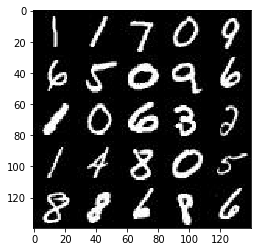

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

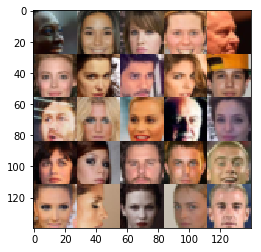

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        fullyCon = tf.layers.dense(z, 7*7*256)
        fullyCon = tf.reshape(fullyCon, (-1, 7, 7, 256))
        fullyCon = tf.layers.batch_normalization(fullyCon, training=is_train)
        fullyCon = tf.maximum(alpha*fullyCon, fullyCon)
        
        conv1 = tf.layers.conv2d_transpose(fullyCon, 128, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv1, 64, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 1, 'SAME')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2637... Generator Loss: 1.8217
Epoch 1/2... Discriminator Loss: 0.2029... Generator Loss: 2.3787
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 0.8597
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 1.5037
Epoch 1/2... Discriminator Loss: 0.2858... Generator Loss: 2.1246
Epoch 1/2... Discriminator Loss: 1.6452... Generator Loss: 0.2640
Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 0.9289
Epoch 1/2... Discriminator Loss: 0.6477... Generator Loss: 2.3800
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 2.3201
Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 1.1971


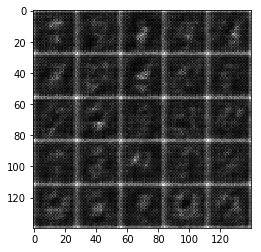

Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.0721
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 1.8068
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.5293
Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 1.6148
Epoch 1/2... Discriminator Loss: 0.8915... Generator Loss: 0.7437
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 1.0790


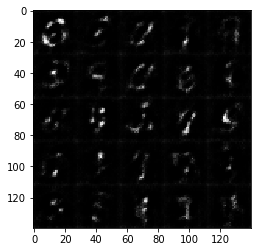

Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.3446
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 0.5400
Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 1.2467
Epoch 1/2... Discriminator Loss: 0.7297... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 0.7548
Epoch 1/2... Discriminator Loss: 0.5552... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 0.5856... Generator Loss: 1.5073
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.4110


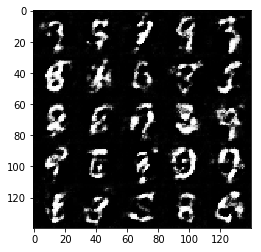

Epoch 1/2... Discriminator Loss: 0.6625... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 1.2647
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 1.6101
Epoch 1/2... Discriminator Loss: 0.5043... Generator Loss: 1.8756
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 1.6828
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 1.1950
Epoch 1/2... Discriminator Loss: 0.5754... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 0.6019... Generator Loss: 1.1454
Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 2.6589


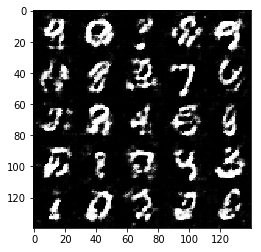

Epoch 1/2... Discriminator Loss: 0.6279... Generator Loss: 1.0959
Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 1.9898
Epoch 1/2... Discriminator Loss: 0.4265... Generator Loss: 1.6351
Epoch 1/2... Discriminator Loss: 0.5877... Generator Loss: 1.1133
Epoch 1/2... Discriminator Loss: 0.4853... Generator Loss: 1.5861
Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 1.3607
Epoch 1/2... Discriminator Loss: 0.8089... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 0.7265... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 0.5878... Generator Loss: 1.3490
Epoch 1/2... Discriminator Loss: 0.6738... Generator Loss: 1.1784


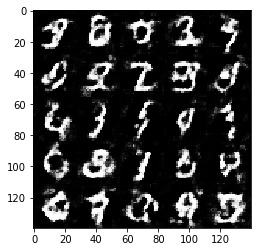

Epoch 1/2... Discriminator Loss: 0.4940... Generator Loss: 1.5319
Epoch 1/2... Discriminator Loss: 0.5782... Generator Loss: 1.2964
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 1.5491
Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 2.0918
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 0.8313... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 2.6099


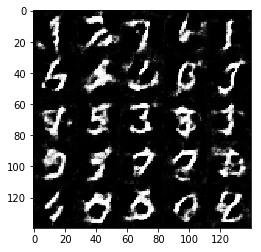

Epoch 1/2... Discriminator Loss: 0.7485... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 0.6167... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 0.8780
Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 2.2922
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 2.2987
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 1.6137
Epoch 1/2... Discriminator Loss: 0.5916... Generator Loss: 1.5355
Epoch 1/2... Discriminator Loss: 0.7931... Generator Loss: 1.9179
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 0.7132


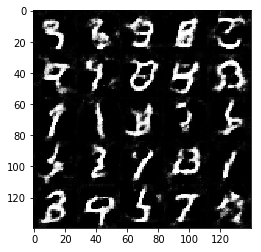

Epoch 1/2... Discriminator Loss: 0.7972... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 0.6362... Generator Loss: 1.5574
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 1.7386
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 0.7815
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.5573
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 1.6837
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 1.8799
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 1.5510


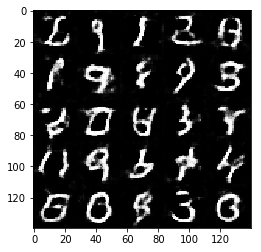

Epoch 1/2... Discriminator Loss: 1.3027... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 1.0684
Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 1.3199
Epoch 1/2... Discriminator Loss: 0.8944... Generator Loss: 0.7793
Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 1.1705
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 2.1216
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 0.7490
Epoch 1/2... Discriminator Loss: 0.7153... Generator Loss: 2.2662
Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.0256


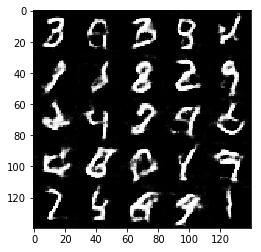

Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.4663
Epoch 1/2... Discriminator Loss: 0.6141... Generator Loss: 1.2214
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 0.6673... Generator Loss: 1.0861
Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.1723
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.6356... Generator Loss: 1.2071


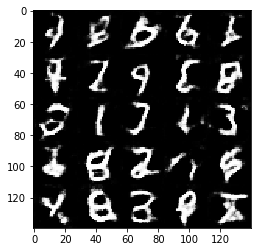

Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 2.0192
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.0064
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 0.9388
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.4867
Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.7478
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 2.2011
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 0.9827
Epoch 2/2... Discriminator Loss: 0.6428... Generator Loss: 1.2694
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 0.9323


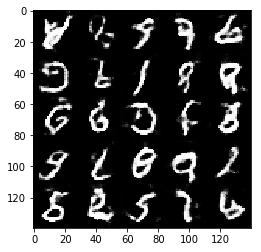

Epoch 2/2... Discriminator Loss: 0.6180... Generator Loss: 1.9038
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.4442
Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 0.5793... Generator Loss: 1.5920
Epoch 2/2... Discriminator Loss: 0.6890... Generator Loss: 1.0768
Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 0.5585... Generator Loss: 2.0359
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 0.6488... Generator Loss: 1.7286


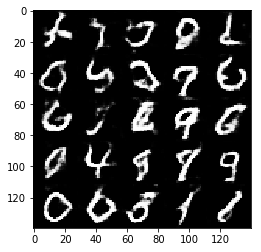

Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 1.5757
Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 1.7690
Epoch 2/2... Discriminator Loss: 0.5394... Generator Loss: 1.4589
Epoch 2/2... Discriminator Loss: 0.7612... Generator Loss: 2.5301
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.3250
Epoch 2/2... Discriminator Loss: 0.5545... Generator Loss: 1.3336
Epoch 2/2... Discriminator Loss: 0.7679... Generator Loss: 1.0115
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.6803
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 0.5497... Generator Loss: 1.8865


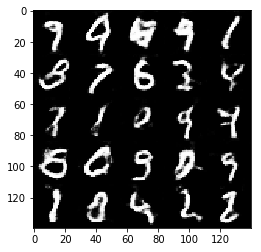

Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 0.5103... Generator Loss: 1.8953
Epoch 2/2... Discriminator Loss: 0.4241... Generator Loss: 1.8123
Epoch 2/2... Discriminator Loss: 0.4805... Generator Loss: 1.5637
Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 1.4393
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 0.6712... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 0.6532... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 1.1121


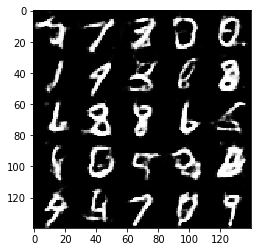

Epoch 2/2... Discriminator Loss: 0.6272... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 1.6745
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 1.0812
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 0.5107... Generator Loss: 1.8179
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 2.2766
Epoch 2/2... Discriminator Loss: 0.9071... Generator Loss: 0.6825
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 1.2918


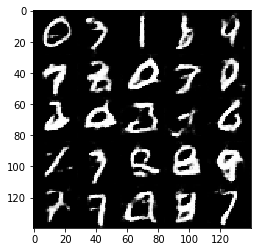

Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.5027
Epoch 2/2... Discriminator Loss: 0.6090... Generator Loss: 1.8289
Epoch 2/2... Discriminator Loss: 0.6641... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.2177
Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.9364
Epoch 2/2... Discriminator Loss: 0.5782... Generator Loss: 1.3195
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.4839
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 0.8303
Epoch 2/2... Discriminator Loss: 0.4582... Generator Loss: 1.9624


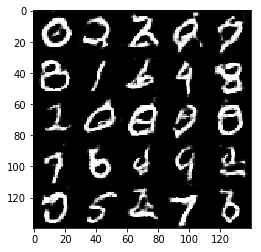

Epoch 2/2... Discriminator Loss: 0.5214... Generator Loss: 1.8143
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 1.3433
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 1.4455
Epoch 2/2... Discriminator Loss: 0.4984... Generator Loss: 1.5212
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 2.9161
Epoch 2/2... Discriminator Loss: 0.5873... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 2.1523
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 1.0621
Epoch 2/2... Discriminator Loss: 0.6139... Generator Loss: 2.1891
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.2827


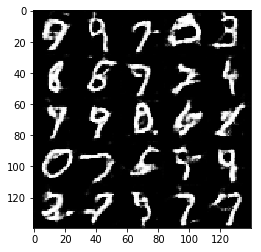

Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.6999
Epoch 2/2... Discriminator Loss: 0.5089... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 1.7873
Epoch 2/2... Discriminator Loss: 0.4974... Generator Loss: 1.5832
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.2370
Epoch 2/2... Discriminator Loss: 0.4711... Generator Loss: 1.8158
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 2.0247
Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 1.4600


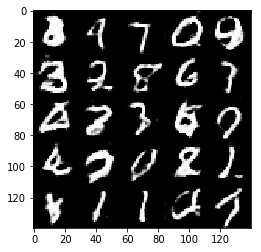

Epoch 2/2... Discriminator Loss: 0.7372... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 0.5744... Generator Loss: 1.2335
Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 1.9806
Epoch 2/2... Discriminator Loss: 1.2483... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 1.1147
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.1527
Epoch 2/2... Discriminator Loss: 0.4949... Generator Loss: 1.7764


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.2347... Generator Loss: 1.8667
Epoch 1/1... Discriminator Loss: 0.2943... Generator Loss: 1.6248
Epoch 1/1... Discriminator Loss: 0.2354... Generator Loss: 2.1029
Epoch 1/1... Discriminator Loss: 0.1431... Generator Loss: 2.4537
Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 0.2949... Generator Loss: 2.9394


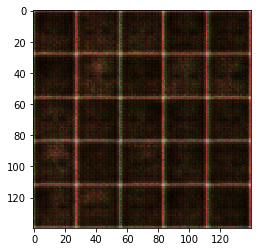

Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 2.0263
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 2.5568
Epoch 1/1... Discriminator Loss: 0.2446... Generator Loss: 2.3244
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 1.8721
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.6334... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 2.5656


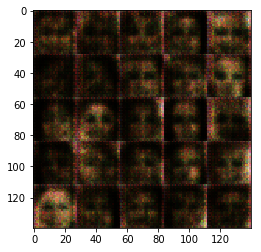

Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 3.3680
Epoch 1/1... Discriminator Loss: 0.1547... Generator Loss: 3.2154
Epoch 1/1... Discriminator Loss: 0.2481... Generator Loss: 2.1864
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 1.2729
Epoch 1/1... Discriminator Loss: 0.7470... Generator Loss: 4.3866
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 1.7780
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 0.6114... Generator Loss: 3.2354
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 1.7051
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.8639


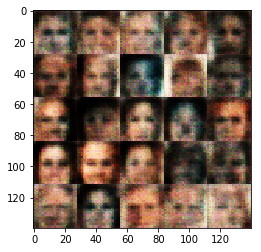

Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 0.3014... Generator Loss: 1.8729
Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 1.9349
Epoch 1/1... Discriminator Loss: 0.4280... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.0538
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 3.2944
Epoch 1/1... Discriminator Loss: 0.4247... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.0206


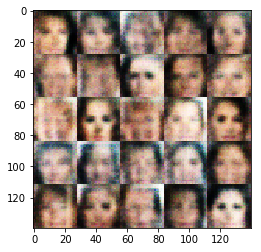

Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 0.3191... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 2.2007
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 1.3516
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 2.5839
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 3.3291
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 2.3060
Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 2.1123


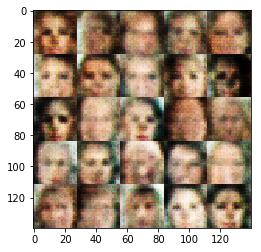

Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 1.9784
Epoch 1/1... Discriminator Loss: 0.6279... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 2.4098
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 1.8269
Epoch 1/1... Discriminator Loss: 0.3050... Generator Loss: 1.8608
Epoch 1/1... Discriminator Loss: 0.4862... Generator Loss: 2.2449
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 3.7079
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.3305
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 1.1428


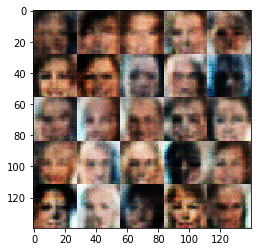

Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.7193
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.8708
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 2.0284
Epoch 1/1... Discriminator Loss: 0.5557... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 1.5515
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.4406... Generator Loss: 1.7392


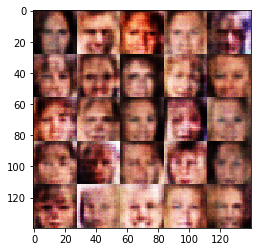

Epoch 1/1... Discriminator Loss: 0.6001... Generator Loss: 2.4462
Epoch 1/1... Discriminator Loss: 0.3135... Generator Loss: 2.2956
Epoch 1/1... Discriminator Loss: 1.6526... Generator Loss: 0.3212
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 1.1522
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 3.6729
Epoch 1/1... Discriminator Loss: 0.4415... Generator Loss: 1.6671
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.2720
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 2.3299
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 0.9662


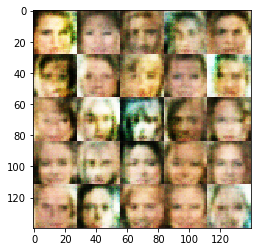

Epoch 1/1... Discriminator Loss: 0.4656... Generator Loss: 2.2078
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 0.7073... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 2.0168
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 0.7858


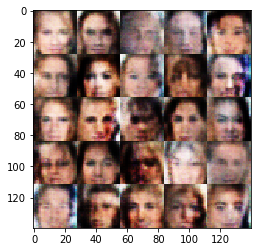

Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 0.4399... Generator Loss: 1.7594
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 3.0134
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.5297


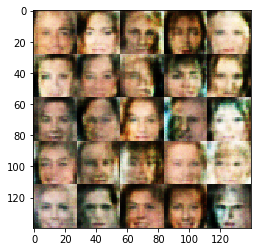

Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 1.9275
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 1.7603
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 2.2594
Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.0694


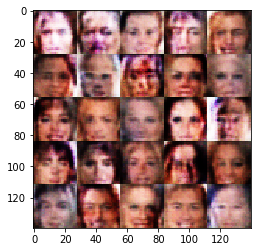

Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 2.1571
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 1.7915
Epoch 1/1... Discriminator Loss: 0.6834... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 1.8168
Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 1.9964


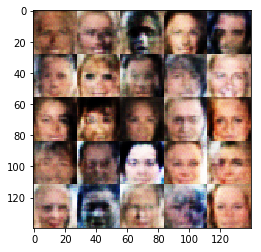

Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 0.7874... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 2.5410
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 2.6166


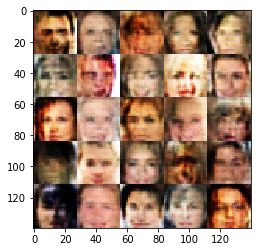

Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 1.7530
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 2.2153
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.6831
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.4481... Generator Loss: 1.6162
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 2.0147
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.0377


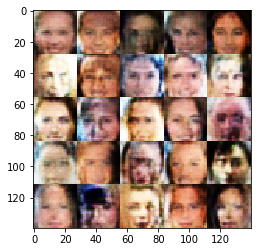

Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 1.6810
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 0.4426... Generator Loss: 1.6967
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 1.5645
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 2.9810
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 0.8873


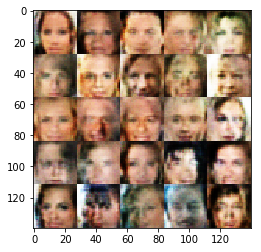

Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 1.9028
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.5273... Generator Loss: 1.7061
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 1.8545
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 2.4357


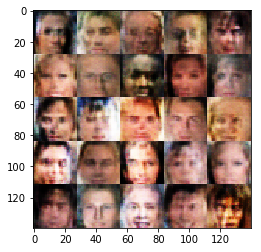

Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 2.0492
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.3234... Generator Loss: 2.5219
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 1.6258
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 1.9046


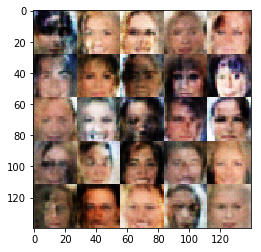

Epoch 1/1... Discriminator Loss: 0.6755... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.4756
Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.2818
Epoch 1/1... Discriminator Loss: 0.6835... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 1.3824
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.7035


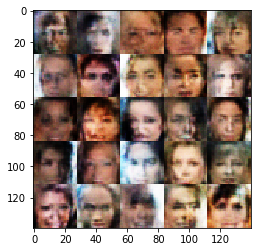

Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 3.5165
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 1.5582
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.4489
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 1.6666


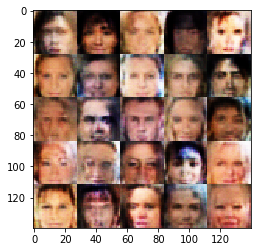

Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 1.5928
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 1.9131
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 3.3305
Epoch 1/1... Discriminator Loss: 0.4984... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.5797... Generator Loss: 1.4597


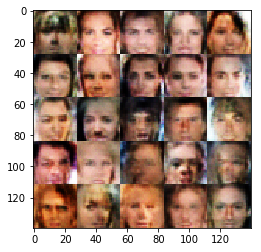

Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 1.9187
Epoch 1/1... Discriminator Loss: 0.4033... Generator Loss: 1.8914
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 2.0926
Epoch 1/1... Discriminator Loss: 0.7050... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.3756
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 1.2369
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.1785


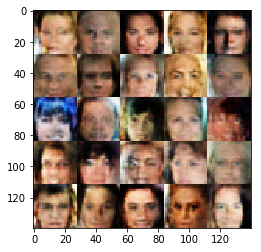

Epoch 1/1... Discriminator Loss: 0.3773... Generator Loss: 1.8118
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 1.5584
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 0.8797... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 2.0401
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.9780
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.1526


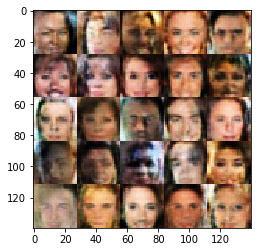

Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.2989
Epoch 1/1... Discriminator Loss: 1.6339... Generator Loss: 0.2753
Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 1.5530
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 0.8391


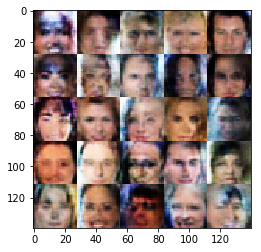

Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 2.0876
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.3435
Epoch 1/1... Discriminator Loss: 0.5187... Generator Loss: 2.2479
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 0.6870


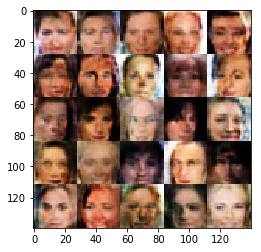

Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 2.7194
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 1.6921
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 1.5162
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.7584
Epoch 1/1... Discriminator Loss: 0.4604... Generator Loss: 1.4160


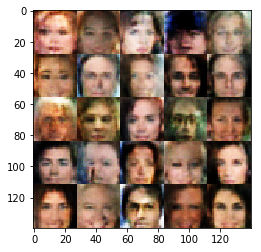

Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 1.6290
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 1.6219
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 1.6680


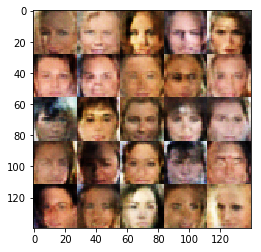

Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 1.4880
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.7647
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 1.4983


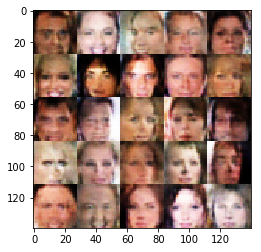

Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.7952


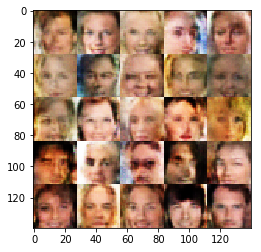

Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.4497
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 1.6308
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.6287
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 1.8318
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 1.9146
Epoch 1/1... Discriminator Loss: 0.2768... Generator Loss: 2.0157
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.0939


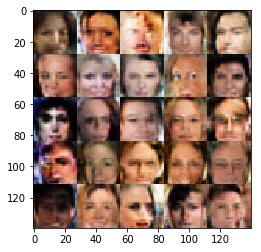

Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 0.5439... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 0.5772... Generator Loss: 1.7979
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.3325
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 2.3300
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.3225


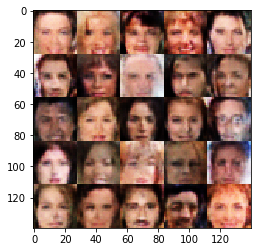

Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 2.2798
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 1.4704


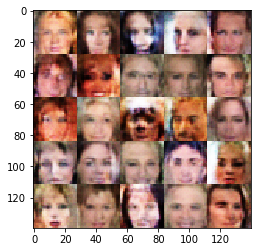

Epoch 1/1... Discriminator Loss: 0.5094... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 0.3171... Generator Loss: 1.8539
Epoch 1/1... Discriminator Loss: 1.9131... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 0.2544... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 1.5398


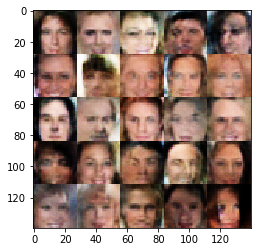

Epoch 1/1... Discriminator Loss: 0.5870... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 0.5239... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.1544
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.5181


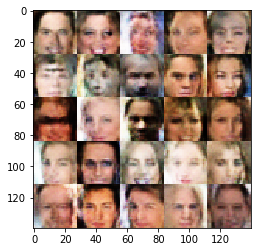

Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 1.5261
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.1817
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.8374
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 1.6575


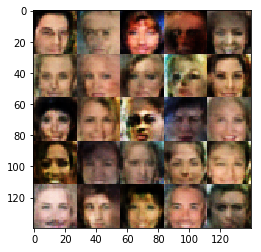

Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 1.5046
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 2.3299
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 2.1149
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 1.1650


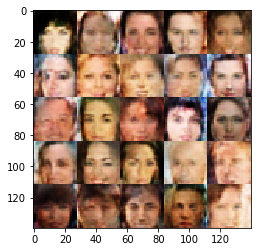

Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 0.3249... Generator Loss: 1.9825
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 2.7082


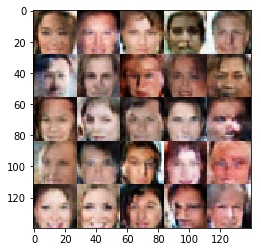

Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 1.4144


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.